# **Import libraries**

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os as os

# **Data preparing**

## **Download dataset from Kaggle**

Guidline: https://www.kaggle.com/discussions/general/74235

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phuonghenry","key":"b2d4e843f72f2176db6ac49c477aa640"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'dogs-vs-cats'

 99% 801M/812M [00:03<00:00, 162MB/s]
100% 812M/812M [00:03<00:00, 229MB/s]


## **Dogs vs. Cats Dataset Preparation**

In [ ]:
! mkdir datasets
! unzip dogs-vs-cats.zip -d datasets

Archive:  dogs-vs-cats.zip
  inflating: datasets/sampleSubmission.csv  
  inflating: datasets/test1.zip      
  inflating: datasets/train.zip      


In [ ]:
# ! mkdir data
! unzip datasets/train.zip -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/train/dog.5499.jpg  
  inflating: datasets/train/dog.55.jpg  
  inflating: datasets/train/dog.550.jpg  
  inflating: datasets/train/dog.5500.jpg  
  inflating: datasets/train/dog.5501.jpg  
  inflating: datasets/train/dog.5502.jpg  
  inflating: datasets/train/dog.5503.jpg  
  inflating: datasets/train/dog.5504.jpg  
  inflating: datasets/train/dog.5505.jpg  
  inflating: datasets/train/dog.5506.jpg  
  inflating: datasets/train/dog.5507.jpg  
  inflating: datasets/train/dog.5508.jpg  
  inflating: datasets/train/dog.5509.jpg  
  inflating: datasets/train/dog.551.jpg  
  inflating: datasets/train/dog.5510.jpg  
  inflating: datasets/train/dog.5511.jpg  
  inflating: datasets/train/dog.5512.jpg  
  inflating: datasets/train/dog.5513.jpg  
  inflating: datasets/train/dog.5514.jpg  
  inflating: datasets/train/dog.5515.jpg  
  inflating: datasets/train/dog.5516.jpg  
  inflating: datasets/train/dog.5517.jpg  
  infla

## **Plot Dog and Cat PhotosPlot Dog and Cat Photos**

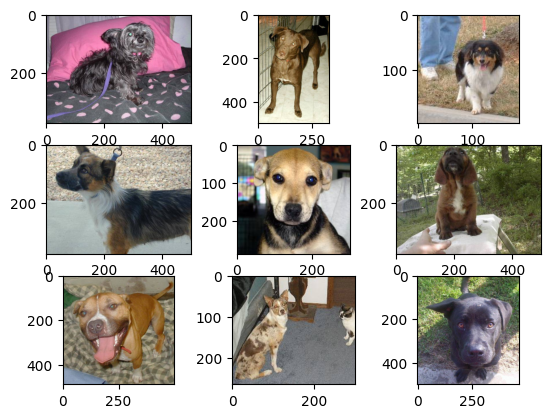

In [ ]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  filename = 'datasets/train/' + 'dog.' + str(i) + '.jpg'
  image = imread(filename)
  plt.imshow(image)
plt.show()

Running the example creates a figure showing the first nine photos of dogs in the dataset.

We can see that some photos are landscape format, some are portrait format, and some are square.

## **Pre-Process Photos into Standard Directories**

We can write a script to create a copy of the dataset with this preferred structure. We will randomly select 25% of the images (or 6,250) to be used in a test dataset.

First, we need to create the directory structure as follows:

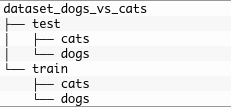

In [ ]:
dst_path = 'data/'

# Remove the folder
# !rm -rf {dst_path}

In [ ]:
sub_dirs = ['train','test']
for dir in sub_dirs:
  sub_path = dst_path + dir

  labels = ['cat', 'dog']
  for label in labels:
    label_dir = sub_path + '/' + label
    os.makedirs(label_dir, exist_ok=True)

We can randomly decide to hold back 25% of the images into the test dataset. This is done consistently by fixing the seed for the pseudorandom number generator so that we get the same split of data each time the code is run.

In [ ]:
import random
from shutil import copyfile

In [ ]:
random.seed(1)
val_ratio = 0.25
src_path = 'datasets/train/'

for file in os.listdir(src_path):
  src = src_path + file
  dst = dst_path + 'train/'

  if random.random() < val_ratio:
    dst = dst_path + 'test/'

  if file.startswith('dog'):
    dst = dst + 'dog/' + file
    copyfile(src, dst)
  elif file.startswith('cat'):
    dst = dst + 'cat/' + file
    copyfile(src, dst)

# **Develop a Baseline CNN Model**

In this section, we can develop a baseline convolutional neural network model for the dogs vs. cats dataset.



A good starting point is the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. For more details on the VGG model, see the 2015 paper “[Very Deep Convolutional Networks for Large-Scale Image Recognition.](https://arxiv.org/abs/1409.1556)”

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can explore this architecture on the dogs vs cats problem and compare a model with this architecture with 1, 2, and 3 blocks.

Each layer will use the ReLU activation function and the He weight initialization, which are generally best practices.

The model will be fit with stochastic gradient descent and we will start with a conservative learning rate of 0.001 and a momentum of 0.9.

The problem is a binary classification task, requiring the prediction of one value of either 0 or 1. An output layer with 1 node and a sigmoid activation will be used and the model will be optimized using the binary cross-entropy loss function.

Defining a convolutional neural network model for the dogs vs. cats problem with one vgg-style block.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import sys
import tensorflow as tf

The summarize_diagnostics() function below takes the history directory and creates a single figure with a line plot of the loss and another for the accuracy. The figure is then saved to file with a filename based on the name of the script. This is helpful if we wish to evaluate many variations of the model in different files and create line plots automatically for each.

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	plt.savefig(filename + '_plot.png')
	plt.show()
	plt.close()

In [ ]:
def check_device():
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available.")
        print(tf.config.list_physical_devices('GPU'))
    else:
        print("No GPU found, training will use the CPU.")

In [ ]:
check_device()

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We can tie all of this together into a simple test harness for testing a model configuration.

In [ ]:
def run(model):
  check_device()

  with tf.device('/GPU:0'):
    model = model()

    # Create data generator
    data_gen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = data_gen.flow_from_directory(dst_path + 'train/', class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = data_gen.flow_from_directory(dst_path + 'test/', class_mode='binary', batch_size=64, target_size=(200, 200))

    # Fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it,
                                  validation_steps=len(test_it), epochs=20, verbose=0)

    # Evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))

    # Plot diagnostic learning curves
    summarize_diagnostics(history)


## **One Block VGG Model**

The one-block VGG model has a single convolutional layer with 32 filters followed by a max pooling layer.

In [ ]:
def model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 71.823


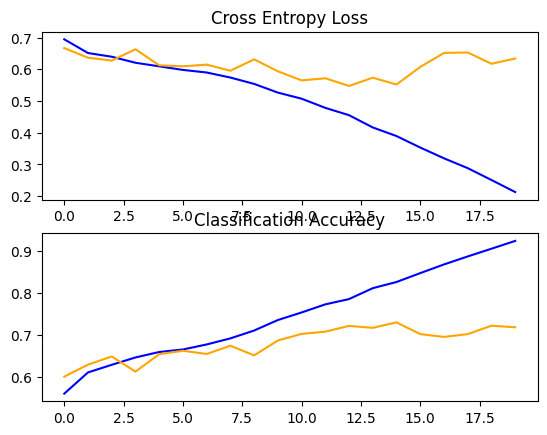

In [ ]:
run(model)

In this case, we can see that the model achieved an accuracy of about 72% on the test dataset.

A figure is also created showing a line plot for the loss and another for the accuracy of the model on both the train (blue) and test (orange) datasets.

Reviewing this plot, we can see that the model has overfit the training dataset at about 12 epochs.

## **Two Blocks VGG Model**

The two-block VGG model extends the one block model and adds a second block with 64 filters.

In [ ]:
def model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(2, 2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 77.281


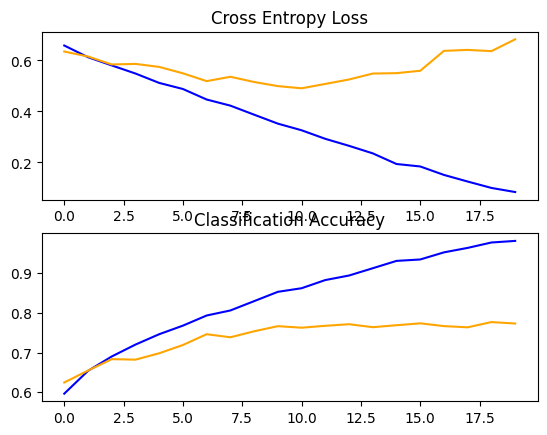

In [ ]:
run(model)

In this case, we can see that the model achieved an accuracy of about 77% on the test dataset.

Reviewing the plot of the learning curves, we can see that again the model appears to have overfit the training dataset, perhaps sooner, in this case at around eight training epochs.

Reviewing this plot, we can see that the model has overfit the training dataset at about 12 epochs.

This is likely the result of the increased capacity of the model, and we might expect this trend of sooner overfitting to continue with the next model.

## **Three Blocks VGG Model**

The two-block VGG model extends the two block model and adds a second block with 128 filters.

In [ ]:
def model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(62, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(2, 2))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(2, 2))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 80.184


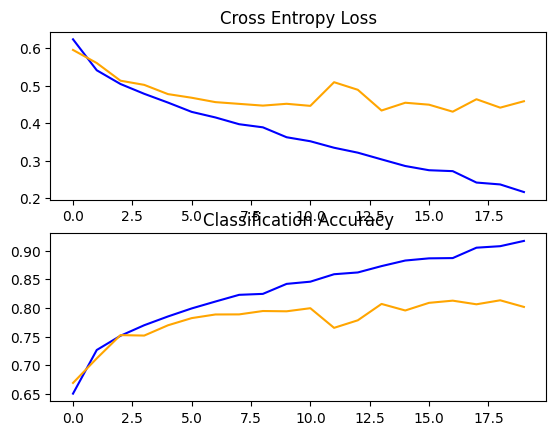

In [ ]:
run(model)

In this case, we can see that we achieved a further lift in performance from about 77% with two blocks to about 80% accuracy with three blocks.

Reviewing the plot of the learning curves, we can see a similar trend of overfitting, in this case perhaps pushed back as far as to epoch five or six.

## **Discussion**

We have explored three different models with a VGG-based architecture.

The results can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

* VGG 1: 71.823%
* VGG 2: 77.281%
* VGG 3: 80.184%

We see a trend of improved performance with the increase in capacity, but also a similar case of overfitting occurring earlier and earlier in the run.

The results suggest that the model will likely benefit from regularization techniques. This may include techniques such as dropout, weight decay, and data augmentation. The latter can also boost performance by encouraging the model to learn features that are further invariant to position by expanding the training dataset.

# **Develop Model Improvements**

In this section, we will start with the baseline model with three VGG blocks (i.e. VGG 3) and explore some simple improvements to the model.

From reviewing the learning curves for the model during training, the model showed strong signs of overfitting. We can explore two approaches to attempt to address this overfitting: **dropout regularization** and **data augmentation**.

Both of these approaches are expected to slow the rate of improvement during training and hopefully counter the overfitting of the training dataset. As such, we will increase the number of training epochs from 20 to 50 to give the model more space for refinement.

## **Dropout Regularization**

In this case, a dropout of 20% is applied after each VGG block, with a larger dropout rate of 50% applied after the fully connected layer in the classifier part of the model.

In [ ]:
from keras.layers import Dropout

In [ ]:
def model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def run(model):
  check_device()

  with tf.device('/GPU:0'):
    model = model()

    # Create data generator
    data_gen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = data_gen.flow_from_directory(dst_path + 'train/', class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = data_gen.flow_from_directory(dst_path + 'test/', class_mode='binary', batch_size=64, target_size=(200, 200))

    # Fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it,
                                  validation_steps=len(test_it), epochs=50, verbose=0)

    # Evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))

    # Plot diagnostic learning curves
    summarize_diagnostics(history)

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 80.835


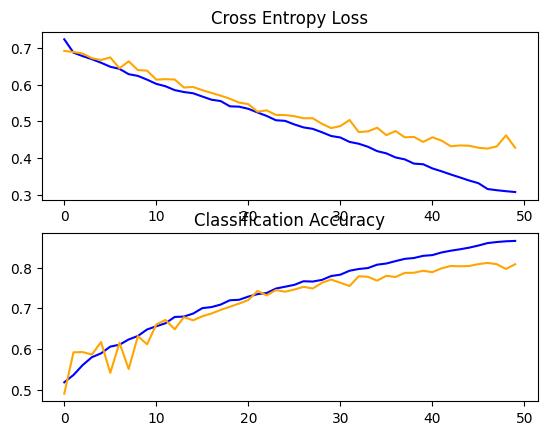

In [ ]:
run(model)

In this case, we can see a small lift in model performance from about 80% accuracy for the baseline model to about 81% with the addition of dropout.

The results suggest that further training epochs may result in further improvement of the model. It may also be interesting to explore perhaps a slightly higher dropout rate after the VGG blocks in addition to the increase in training epochs.

## **Data Augmentation**

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

Data augmentation can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input.

Small changes to the input photos of dogs and cats might be useful for this problem, such as small shifts and horizontal flips. These augmentations can be specified as arguments to the ImageDataGenerator used for the training dataset. The augmentations should not be used for the test dataset, as we wish to evaluate the performance of the model on the unmodified photographs.

This requires that we have a separate ImageDataGenerator instance for the train and test dataset, then iterators for the train and test sets created from the respective data generators.

In this case, photos in the training dataset will be augmented with small (10%) random horizontal and vertical shifts and random horizontal flips that create a mirror image of a photo. Photos in both the train and test steps will have their pixel values scaled in the same way.

In [ ]:
def model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(62, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(2, 2))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D(2, 2))
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def run(model):
  check_device()

  with tf.device('/GPU:0'):
    model = model()

    # Create data generator
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = train_datagen.flow_from_directory(dst_path + 'train/', class_mode='binary',
                                                 batch_size=64, target_size=(200, 200))
    test_it = test_datagen.flow_from_directory(dst_path + 'test/', class_mode='binary',
                                               batch_size=64, target_size=(200, 200))

    # Fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it,
                                  validation_steps=len(test_it), epochs=50, verbose=0)

    # Evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))

    # Plot diagnostic learning curves
    summarize_diagnostics(history)

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 85.848


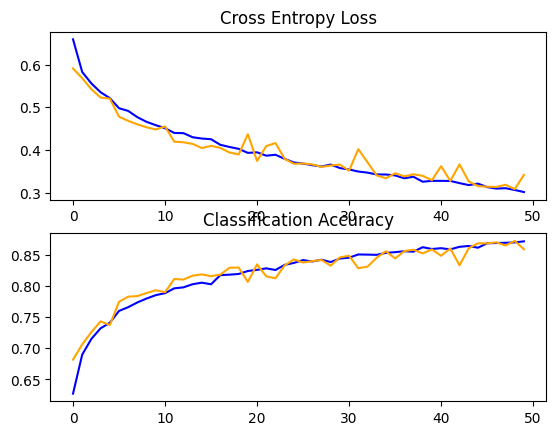

In [ ]:
run(model)

In this case, we can see a lift in performance of about 5% from about 80% for the baseline model to about 85% for the baseline model with simple data augmentation.

Reviewing the learning curves, we can see that it appears the model is capable of further learning with both the loss on the train and test dataset still decreasing even at the end of the run. Repeating the experiment with 100 or more epochs will very likely result in a better performing model.

It may be interesting to explore other augmentations that may further encourage the learning of features invariant to their position in the input, such as minor rotations and zooms.

## **Dropout Regulization + Data Augmentation**

We will combine Dropout and Data Augmentation into a single model.

In [ ]:
def model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def run(model):
  check_device()

  with tf.device('/GPU:0'):
    model = model()

    # Create data generator
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_it = train_datagen.flow_from_directory(dst_path + 'train/', class_mode='binary',
                                                 batch_size=64, target_size=(200, 200))
    test_it = test_datagen.flow_from_directory(dst_path + 'test/', class_mode='binary',
                                               batch_size=64, target_size=(200, 200))

    # Fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it,
                                  validation_steps=len(test_it), epochs=50, verbose=0)

    # Evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))

    # Plot diagnostic learning curves
    summarize_diagnostics(history)

In [ ]:
run(model)

## **Discussion**

We have explored three different improvements to the baseline model.

The results can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

* Baseline VGG3 + Dropout: 80.835%
* Baseline VGG3 + Data Augmentation: 85.848%
* Baseline VGG3 + Dropout + Data Augmentation:

As suspected, the addition of regularization techniques slows the progression of the learning algorithms and reduces overfitting, resulting in improved performance on the holdout dataset. It is likely that the combination of both approaches with further increase in the number of training epochs will result in further improvements.

# **Explore Transfer Learning**

A useful model for transfer learning is one of the VGG models, such as VGG-16 with 16 layers that at the time it was developed, achieved top results on the ImageNet photo classification challenge.

The model is comprised of two main parts, the feature extractor part of the model that is made up of VGG blocks, and the classifier part of the model that is made up of fully connected layers and the output layer.

We can use the feature extraction part of the model and add a new classifier part of the model that is tailored to the dogs and cats dataset. Specifically, we can hold the weights of all of the convolutional layers fixed during training, and only train new fully connected layers that will learn to interpret the features extracted from the model and make a binary classification.

This can be achieved by loading the VGG-16 model, removing the fully connected layers from the output-end of the model, then adding the new fully connected layers to interpret the model output and make a prediction. The classifier part of the model can be removed automatically by setting the “include_top” argument to “False“, which also requires that the shape of the input also be specified for the model, in this case (224, 224, 3). This means that the loaded model ends at the last max pooling layer, after which we can manually add a Flatten layer and the new clasifier layers.

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [ ]:
def model():
  model = VGG16(include_top=False, input_shape=(224, 224, 3))

  # mark loaded layers as not trainable
  for layer in model.layers:
    layer.trainable = False

  # add new classifier layers
  flat = Flatten()(model.layers[-1].output)
  class_1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat)
  output = Dense(1, activation='sigmoid')(class_1)

  # define a new model
  model = Model(inputs=model.inputs, outputs=output)
  opt = SGD(learning_rate=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  return model

Once created, we can train the model as before on the training dataset.

Not a lot of training will be required in this case, as only the new fully connected and output layer have trainable weights. As such, we will fix the number of training epochs at 10.

The VGG16 model was trained on a specific ImageNet challenge dataset. As such, it is configured to expected input images to have the shape 224×224 pixels. We will use this as the target size when loading photos from the dogs and cats dataset.

The model also expects images to be centered. That is, to have the mean pixel values from each channel (red, green, and blue) as calculated on the ImageNet training dataset subtracted from the input. Keras provides a function to perform this preparation for individual photos via the preprocess_input() function. Nevertheless, we can achieve the same effect with the ImageDataGenerator by setting the “featurewise_center” argument to “True” and manually specifying the mean pixel values to use when centering as the mean values from the ImageNet training dataset: [123.68, 116.779, 103.939].

In [ ]:
def run(model):
  check_device()

  with tf.device('/GPU:0'):
    model = model()

    # Create data generator
    data_gen = ImageDataGenerator(featurewise_center=True)
    data_gen.mean = [123.68, 116.779, 103.939]
    train_it = data_gen.flow_from_directory(dst_path + 'train/', class_mode='binary',
                                                 batch_size=64, target_size=(224, 224))
    test_it = data_gen.flow_from_directory(dst_path + 'test/', class_mode='binary',
                                               batch_size=64, target_size=(224, 224))

    # Fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it,
                                  validation_steps=len(test_it), epochs=10, verbose=0)

    # Evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))

    # Plot diagnostic learning curves
    summarize_diagnostics(history)

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 97.890


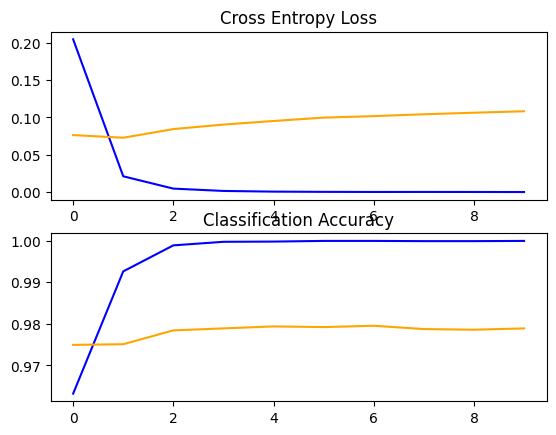

In [ ]:
run(model)

In this case, we can see that the model achieved very impressive results with a classification accuracy of about 97% on the holdout test dataset.

Reviewing the learning curves, we can see that the model fits the dataset quickly. It does not show strong overfitting,

# **Finalize the Model and Make Predictions**

At some point, a final model configuration must be chosen and adopted. In this case, we will keep things simple and use the VGG-16 transfer learning approach as the final model.

First, we will finalize our model by fitting a model on the entire training dataset and saving the model to file for later use. We will then load the saved model and use it to make a prediction on a single image.

## **Prepare Final Dataset**

A final model is typically fit on all available data, such as the combination of all train and test datasets.

In this tutorial, we will demonstrate the final model fit only on the training dataset as we only have labels for the training dataset.

The first step is to prepare the training dataset so that it can be loaded by the ImageDataGenerator class via flow_from_directory() function. Specifically, we need to create a new directory with all training images organized into dogs/ and cats/ subdirectories without any separation into train/ or test/ directories.

This can be achieved by updating the script we developed at the beginning of the tutorial. In this case, we will create a new finalize_dogs_vs_cats/ folder with dogs/ and cats/ subfolders for the entire training dataset.

The structure will look as follows:

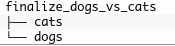

In [ ]:
data_home = 'finalize_dogs_vs_cats/'
label_dirs = ['cats/', 'dogs/']

src_dir = 'datasets/train/'

for label in label_dirs:
  new_dir = data_home + label
  os.makedirs(new_dir)

for fl in os.listdir(src_dir):
  fl_dir = src_dir + fl
  if fl.startswith('cat'):
    dst_dir = data_home + 'cats/' + fl
    copyfile(fl_dir, dst_dir)
  elif fl.startswith('dog'):
    dst_dir = data_home + 'dogs/' + fl
    copyfile(fl_dir, dst_dir)

In [ ]:
# !rm -rf {'finalize_dogs_vs_cats'}

## **Save Final Model**

We are now ready to fit a final model on the entire training dataset.

The flow_from_directory() must be updated to load all of the images from the new finalize_dogs_vs_cats/ directory.

In [ ]:
def run(model):
  check_device()

  with tf.device('/GPU:0'):
    model = model()

    # Create data generator
    data_gen = ImageDataGenerator(featurewise_center=True)
    data_gen.mean = [123.68, 116.779, 103.939]
    train_it = data_gen.flow_from_directory(data_home, class_mode='binary',
                                                 batch_size=64, target_size=(224, 224))

    # Fit model
    model.fit(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)

    # Save model
    model.save('final_model.h5')

In [ ]:
# Train
run(model)

GPU is available.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 25000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **Make Prediction**

We can use our saved model to make a prediction on new images.

The model assumes that new images are color and they have been segmented so that one image contains at least one dog or cat.

Below is an image extracted from the test dataset for the dogs and cats competition. It has no label, but we can clearly tell it is a photo of a dog or cat. You can save it in your current working directory with the filename ‘sample_image.jpg‘.

In [ ]:
! unzip datasets/test1.zip -d sample_data/dogs_vs_cats

Streaming output truncated to the last 5000 lines.
  inflating: sample_data/dogs_vs_cats/test1/5499.jpg  
  inflating: sample_data/dogs_vs_cats/test1/55.jpg  
  inflating: sample_data/dogs_vs_cats/test1/550.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5500.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5501.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5502.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5503.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5504.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5505.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5506.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5507.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5508.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5509.jpg  
  inflating: sample_data/dogs_vs_cats/test1/551.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5510.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5511.jpg  
  inflating: sample_data/dogs_vs_cats/test1/5512.jpg  
  inflating: sampl

Plot a random image in the sample

In [ ]:
def show_image(file_name):
  plt.figure(figsize=(3, 3))
  image = imread(file_name)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

We will pretend this is an entirely new and unseen image, prepared in the required way, and see how we might use our saved model to predict the integer that the image represents. For this example, we expect class “1” for “Dog“.

Note: the subdirectories of images, one for each class, are loaded by the flow_from_directory() function in alphabetical order and assigned an integer for each class. The subdirectory “cat” comes before “dog“, therefore the class labels are assigned the integers: cat=0, dog=1. This can be changed via the “classes” argument in calling flow_from_directory() when training the model.

First, we can load the image and force it to the size to be 224×224 pixels. The loaded image can then be resized to have a single sample in a dataset. The pixel values must also be centered to match the way that the data was prepared during the training of the model. The load_image() function implements this and will return the loaded image ready for classification.

In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [ ]:
def load_image(file_name):
  img = load_img(file_name, target_size=(224, 224))

  # Convert an imgage to array
  img_arr = img_to_array(img)

  # reshape into a single sample with 3 channels
  img_arr = img_arr.reshape(1, 224, 224, 3)
  # center pixel data
  img_arr = img_arr.astype('float32')
  img_arr = img_arr - [123.68, 116.779, 103.939]
  return img_arr

Make prediction

In [ ]:
def run_sample():
  # Get a sample
  random_number = random.randint(1, 12500)
  # print(random_number)
  fl = 'sample_data/dogs_vs_cats/test1/' + str(random_number) + '.jpg'
  # print(fl)

  # Load image
  img = load_image(fl)

  # Load model
  model = load_model('final_model.h5')

  # Show the image fist
  show_image(fl)

  # Predict
  result = model.predict(img)

  print('\n')
  print('*********\n')
  print(result[0])
  if result[0] == 0:
    print('This is a Cat\n')
  elif result[0] == 1:
    print('This is a Dog\n')

  print('*********\n')

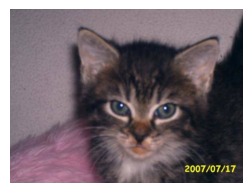

1/1 [==============================] - 0s 214ms/step


*********

[0.]
This is a Cat

*********



In [ ]:
run_sample()